In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel, RBF, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process.kernels import ExpSineSquared, DotProduct
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score

Gaussian Process toy example (Latent f2 and posterior predictive for y)


Fit a Gaussian Process (GP) $y_{std} = GP(0, k(x, x'))$ with $k(x, x')$ a RBF kernel\
We add some Gaussian nose using $N(0, \sigma_y^2)$ to mimic randomness and model noise\
GP samples new predictions with mean and variance\
assume known $f_1$: ``exp_f2_mean = np.exp(f2_mean)``

### TO-DO
- was wissen wir über die funktionen aus unserem Datensatz
- wie sieht der Datensatz aus
- Piecewise invertible

# Known $f_1$ and unknown $f_2$

Compositional GP for a known f1 and learn a latent f2

f2 is unknown, learn it by using a GP and invert the relationship to $f_2^{pseudo} = log(y)$\
use one GP with a RBF kernel to learn the inverse latent representation of $f_2 = log(y)$\
Assume that we directly know $f_1$ and can use it to predict the results of the convolution $f_1(f_2(x))$

Using the GP: GP learns $GP(X, log(y))$, with $X$ generated linspace points and $y=f_1(f_2(X))$.\
Then we predict the values of $f_2$ for 200 randomly drawn points $X^*$ where we get the mean and std values for the pred\
Insert the mean pred into $f_1$ to get the overall prediction.


## RBF kernel

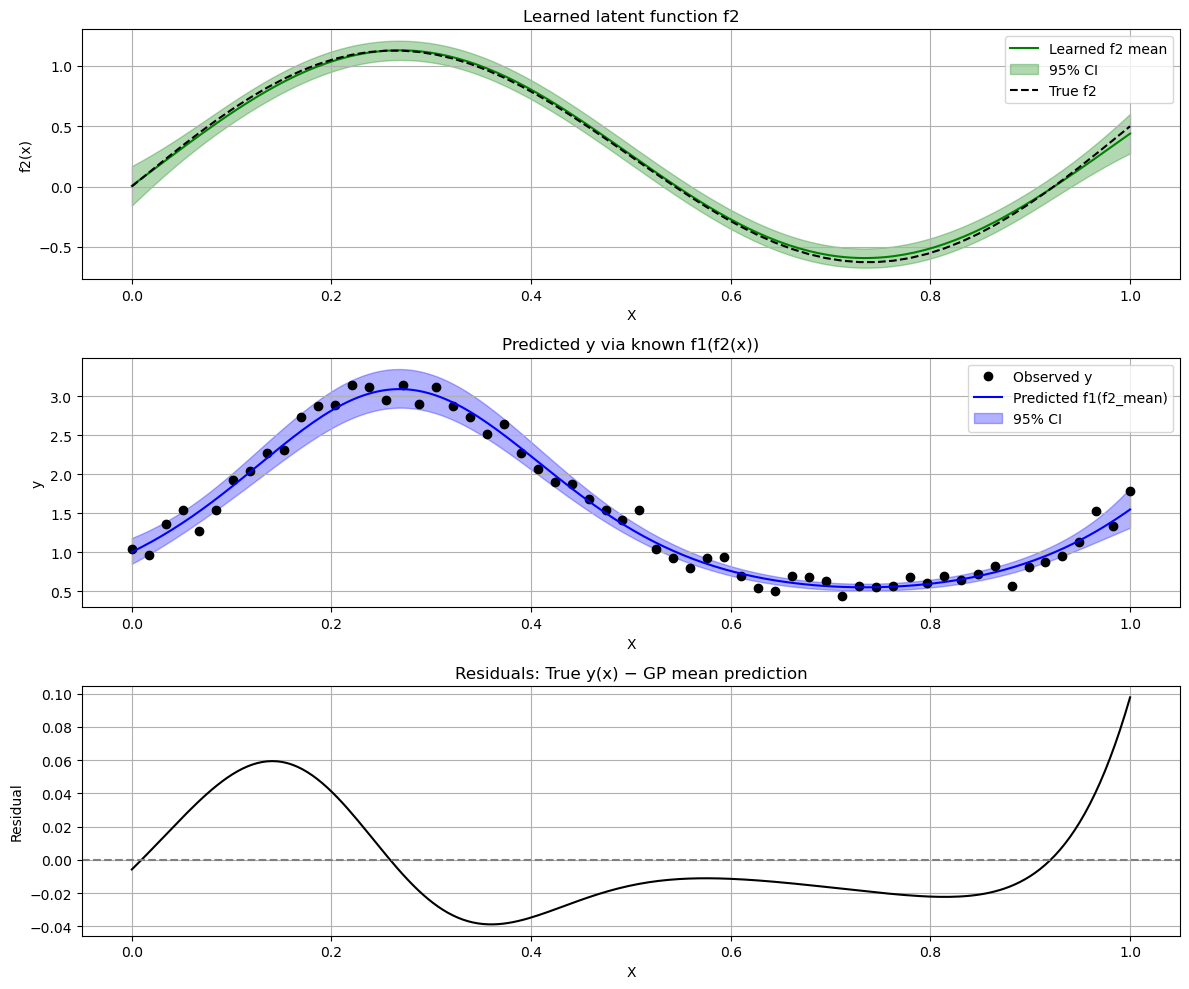

In [4]:
rng = np.random.default_rng(42)

def f2_true(x):            
    return np.sin(2*np.pi*x) + 0.5*x

def f1(z):                 
    return np.exp(z)

n = 60
X = np.linspace(0, 1, n)[:, None]
sigma_y = 0.15
y = f1(f2_true(X)).ravel() + rng.normal(0, sigma_y, size=n)

f2_pseudo = np.log(y)

# -------------------------
# Fit GP to learn latent f2
# -------------------------
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp_f2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=sigma_y**2)
gp_f2.fit(X, f2_pseudo)

# -------------------------
# Predict latent f2
# -------------------------
X_star = np.linspace(0, 1, 200)[:, None]
f2_mean, f2_std = gp_f2.predict(X_star, return_std=True)
f2_hi = f2_mean + 1.96*f2_std
f2_lo = f2_mean - 1.96*f2_std

# -------------------------
# 5. Predict outer y via f1(f2)
# -------------------------
y_pred = f1(f2_mean)
y_hi = f1(f2_hi)
y_lo = f1(f2_lo)

y_true_star = f1(f2_true(X_star)).ravel()
X_pred_flat = X_star.ravel()

# -------------------------
# 6. Plot results
# -------------------------
plt.figure(figsize=(12, 10))

# Top: latent f2
ax1 = plt.subplot(3,1,1)
ax1.plot(X_star, f2_mean, 'g', label="Learned f2 mean")
ax1.fill_between(X_star.ravel(), f2_lo, f2_hi, color='green', alpha=0.3, label="95% CI")
ax1.plot(X, f2_true(X), 'k--', label="True f2")
ax1.set_xlabel("X")
ax1.set_ylabel("f2(x)")
ax1.set_title("Learned latent function f2")
ax1.legend()
ax1.grid(True)

# Bottom: observations / reconstructed y
ax2 = plt.subplot(3,1,2)
ax2.plot(X, y, 'o', color='black', label="Observed y")
ax2.plot(X_star, y_pred, 'b', label="Predicted f1(f2_mean)")
ax2.fill_between(X_star.ravel(), y_lo, y_hi, color='blue', alpha=0.3, label="95% CI")
ax2.set_xlabel("X")
ax2.set_ylabel("y")
ax2.set_title("Predicted y via known f1(f2(x))")
ax2.legend()
ax2.grid(True)

ax3 = plt.subplot(3, 1, 3)
residuals = y_true_star - y_pred
ax3.plot(X_pred_flat, residuals, 'k', lw=1.5)
ax3.axhline(0, color='gray', linestyle='--')
ax3.set_title("Residuals: True y(x) − GP mean prediction")
ax3.set_xlabel("X")
ax3.set_ylabel("Residual")
ax3.grid(True)

plt.tight_layout()
plt.savefig("RBF_kernel.pdf")
plt.show()
plt.close()



## NTK kernel

In [5]:
class NTKReLU(Kernel):
    """Neural Tangent Kernel for a fully-connected, infinite-width, depth-1 ReLU net.
    For depth=1, NTK == NNGP (arc-cosine order-1) kernel.

    k(x, x') = sigma_b^2 + sigma_w^2 * ||x|| ||x'|| * J(theta)
    where theta = arccos( (x·x') / (||x|| ||x'||) ),
    J(theta) = [sin(theta) + (pi - theta) cos(theta)] / (2*pi)
    """
    def __init__(self, sigma_w=1.0, sigma_b=1.0):
        self.sigma_w = float(sigma_w)
        self.sigma_b = float(sigma_b)
        self.is_stationary = False

    def __repr__(self):
        return f"NTKReLU(sigma_w={self.sigma_w}, sigma_b={self.sigma_b})"

    def __call__(self, X, Y=None, eval_gradient=False):
        import numpy as _np
        X = _np.atleast_2d(X)
        Y = X if Y is None else _np.atleast_2d(Y)
        dot = X @ Y.T
        nx = _np.linalg.norm(X, axis=1)
        ny = _np.linalg.norm(Y, axis=1)
        denom = _np.outer(nx, ny)
        with _np.errstate(invalid='ignore', divide='ignore'):
            cos = dot / (denom + 1e-12)
        cos = _np.clip(cos, -1.0, 1.0)
        theta = _np.arccos(cos)
        J = (_np.sin(theta) + (np.pi - theta) * cos) / (2.0 * np.pi)
        K = (self.sigma_b ** 2) + (self.sigma_w ** 2) * (denom * J)
        if eval_gradient:
            return K, _np.empty(K.shape + (0,))
        return K

    def diag(self, X):
        import numpy as _np
        X = _np.atleast_2d(X)
        nx = _np.linalg.norm(X, axis=1)
        return (self.sigma_b ** 2) + (self.sigma_w ** 2) * (nx ** 2) * 0.5

    def is_stationary(self):
        return False

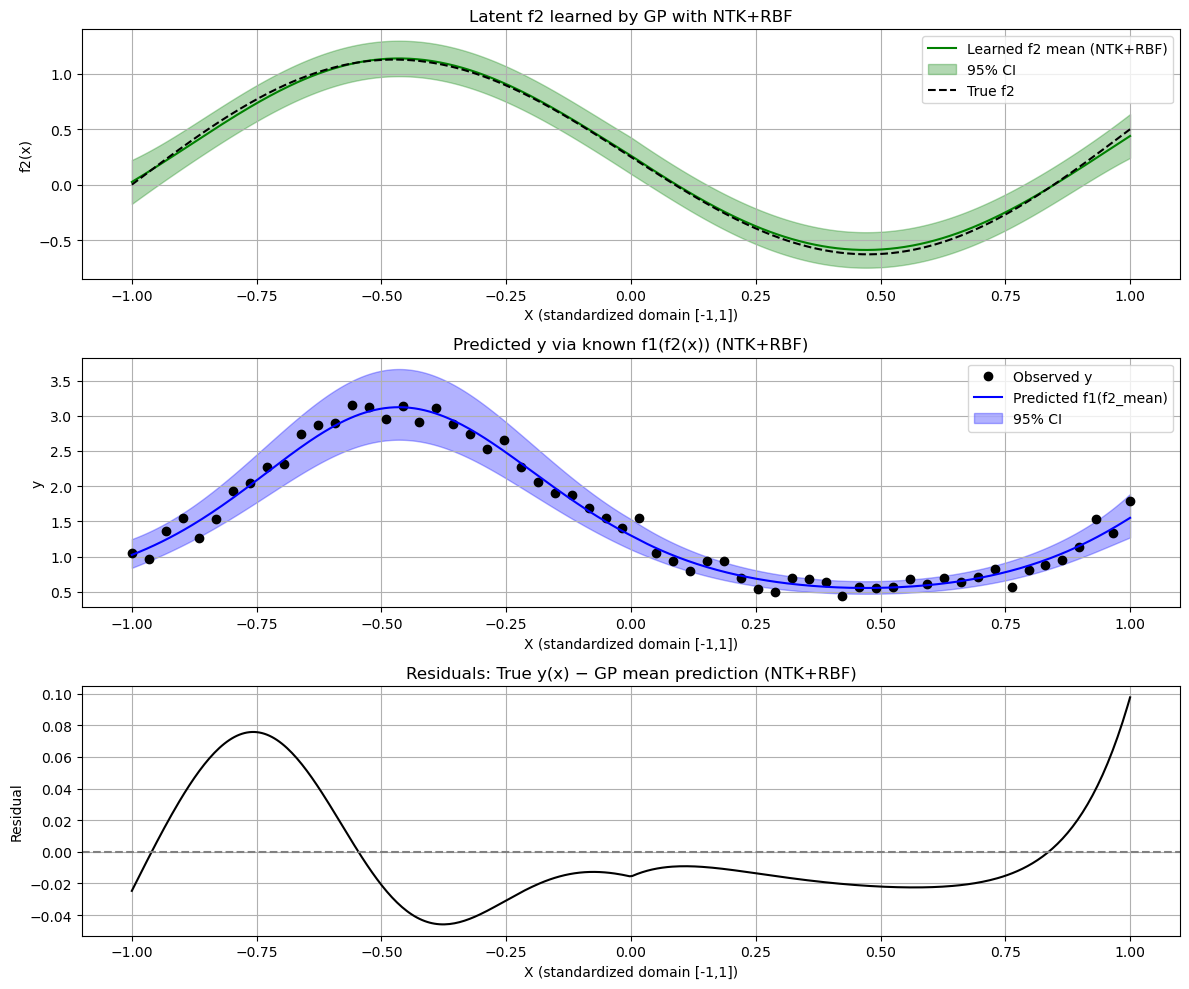

In [6]:
def f2_true(x):            
    return np.sin(2*np.pi*x) + 0.5*x

def f1(z):                 
    return np.exp(z)


rng = np.random.default_rng(42)

# Standardized inputs on [-1,1], but generate y from original [0,1] mapping for comparability
X = np.linspace(-1, 1, n)[:, None]
X_orig = (X + 1)/2.0
y = f1(f2_true(X_orig)).ravel() + rng.normal(0, 0.15, size=60)

# Log pseudo-inverse to approximate latent f2 (note: induces heteroskedasticity)
f2_pseudo = np.log(np.maximum(y, 1e-12))

# -------------------------
# Hybrid kernel: NTKReLU + RBF (+ small white noise)
# -------------------------
ntk = NTKReLU(sigma_w=1.0, sigma_b=1.0)
rbf = RBF(length_scale=0.3)     # tweak length_scale (or allow optimizer to move it)
white = WhiteKernel(noise_level=1e-5)
kernel = ntk + rbf + white

gp_f2 = GaussianProcessRegressor(
    kernel=kernel,
    alpha=sigma_y**2,           # observation noise variance after log approx
    normalize_y=True,
    n_restarts_optimizer=2
)
gp_f2.fit(X, f2_pseudo)

# Predictions
X_star = np.linspace(-1, 1, 400)[:, None]
X_star_orig = (X_star + 1)/2.0
f2_mean, f2_std = gp_f2.predict(X_star, return_std=True)
f2_hi = f2_mean + 1.96*f2_std
f2_lo = f2_mean - 1.96*f2_std

# Compose back through f1
y_pred = f1(f2_mean)
y_hi = f1(f2_hi)
y_lo = f1(f2_lo)
y_true_star = f1(f2_true(X_star_orig)).ravel()

# -------------------------
# Plots: each figure separate
# -------------------------

plt.figure(figsize=(12, 10))

# Top: latent f2
ax1 = plt.subplot(3,1,1)
ax1.plot(X_star, f2_mean, 'g', label="Learned f2 mean (NTK+RBF)")
ax1.fill_between(X_star.ravel(), f2_lo, f2_hi, color='green', alpha=0.3, label="95% CI")
ax1.plot(X_star, f2_true(X_star_orig), "k--", label="True f2")
ax1.set_xlabel("X (standardized domain [-1,1])")
ax1.set_ylabel("f2(x)")
ax1.set_title("Latent f2 learned by GP with NTK+RBF")
ax1.legend()
ax1.grid(True)

# 2) Observations vs prediction
ax2 = plt.subplot(3,1,2)
ax2.plot(X, y, 'o', color='black', label="Observed y")
ax2.plot(X_star, y_pred, color='blue', label="Predicted f1(f2_mean)")
ax2.fill_between(X_star.ravel(), y_lo, y_hi, color='blue', alpha=0.3, label="95% CI")
ax2.set_xlabel("X (standardized domain [-1,1])")
ax2.set_ylabel("y")
ax2.set_title("Predicted y via known f1(f2(x)) (NTK+RBF)")
ax2.legend()
ax2.grid(True)

# 3) Residuals
residuals = y_true_star - y_pred
ax3 = plt.subplot(3,1,3)
ax3.plot(X_star.ravel(), residuals, 'k', lw=1.5)
ax3.axhline(0, color='gray', linestyle='--')
ax3.set_title("Residuals: True y(x) − GP mean prediction (NTK+RBF)")
ax3.set_xlabel("X (standardized domain [-1,1])")
ax3.set_ylabel("Residual")
ax3.grid(True)

plt.tight_layout()
plt.savefig("NTK_RBF_kernel.pdf")
plt.show()
plt.close()

In [35]:
# Reproduce Fig.2-style curves (NN ensemble vs NTK vs NNGP) on your 1D toy data.

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -------------------------
# 0) Toy data (your setup)
# -------------------------
rng = np.random.default_rng(42)

def f2_true(x):
    return np.sin(2*np.pi*x) + 0.5*x

def f1(z):
    return np.exp(z)

n = 60
X = np.linspace(0, 1, n)[:, None].astype(np.float32)
sigma_y = 0.05  # small noise to keep things clean for kernel matches
y = (f1(f2_true(X)) + rng.normal(0, sigma_y, size=(n,1))).astype(np.float32)

# choose two training inputs to define the interpolation path (as in Fig. 2)
i1, i2 = 10, 40
x1, x2 = X[i1:i1+1], X[i2:i2+1]
alphas = np.linspace(-2, 3, 200).astype(np.float32)
X_path = (alphas[:,None]*x2 + (1-alphas[:,None])*x1).astype(np.float32)  # (200,1)

# utility tensors
Xt = torch.from_numpy(X)
yt = torch.from_numpy(y)
Xpatht = torch.from_numpy(X_path)

# -------------------------
# 1) NN ensemble (black)
# -------------------------
class SmallFC(nn.Module):
    def __init__(self, width=128, depth=3, sigma_w=1.5, bias=False):
        super().__init__()
        layers = []
        dims = [1] + [width]*depth + [1]
        # custom init to roughly mirror paper (tanh, σ_w ~ 1.5, no bias)
        act = nn.Tanh()
        for a,b in zip(dims[:-1], dims[1:]):
            lin = nn.Linear(a,b, bias=bias)
            with torch.no_grad():
                nn.init.normal_(lin.weight, mean=0.0, std=sigma_w/np.sqrt(a))
            layers += [lin]
            if b != 1: layers += [act]
        self.net = nn.Sequential(*layers)

    def forward(self, x): return self.net(x)

def train_one(seed, steps, lr):
    torch.manual_seed(seed)
    m = SmallFC(width=256, depth=3, sigma_w=1.5, bias=False)
    opt = optim.SGD(m.parameters(), lr=lr)
    loss_fn = nn.MSELoss(reduction='mean')
    # full-batch GD to match setting
    with torch.no_grad():
        preds0 = m(Xpatht)  # t=0
    preds_by_t = {0: preds0.detach().cpu().numpy().ravel()}
    for t in range(1, max(steps)+1):
        opt.zero_grad()
        pred = m(Xt)
        loss = loss_fn(pred, yt)
        loss.backward()
        opt.step()
        if t in steps:
            with torch.no_grad():
                preds_by_t[t] = m(Xpatht).detach().cpu().numpy().ravel()
    return preds_by_t

# ensemble
T_LIST = [0, 16, 256, 65536]  # same checkpoints as Fig. 2 (interpreted as GD steps)
LR = 0.05
ENSEMBLE = 50  # set to 100 if you have time/compute

ensemble_preds = {t: [] for t in T_LIST}
for s in range(ENSEMBLE):
    out = train_one(seed=1234+s, steps=T_LIST, lr=LR)
    for t in T_LIST:
        ensemble_preds[t].append(out[t])
for t in T_LIST:
    ensemble_preds[t] = np.stack(ensemble_preds[t], axis=0)  # (M, 200)
ensemble_mean = {t: ensemble_preds[t].mean(0) for t in T_LIST}
ensemble_std  = {t: ensemble_preds[t].std(0)  for t in T_LIST}

# -------------------------
# 2) Empirical NTK at init  (blue; Eqs. 14–15)
# -------------------------
# Build one randomly initialized network; freeze it to compute empirical NTK J J^T at t=0
torch.manual_seed(0)
net_for_ntk = SmallFC(width=256, depth=3, sigma_w=1.5, bias=False)
params = [p for p in net_for_ntk.parameters()]
num_params = sum(p.numel() for p in params)

def jac_row(model, x):
    # returns flattened grad wrt all params for scalar output f(x)
    model.zero_grad(set_to_none=True)
    yhat = model(x)
    (yhat.squeeze()).backward()
    return torch.cat([p.grad.reshape(-1) for p in model.parameters()]).detach().clone()

# J_train: (n, P)
J_train = torch.stack([jac_row(net_for_ntk, Xt[i:i+1]) for i in range(len(X))], dim=0)
# NTK matrices:
Theta = (J_train @ J_train.T).numpy()                           # (n,n)
# J_path: (m, P)
J_path = torch.stack([jac_row(net_for_ntk, Xpatht[i:i+1]) for i in range(len(X_path))], dim=0)
Theta_xX = (J_path @ J_train.T).numpy()                         # (m,n)
K0 = (net_for_ntk(Xpatht).detach().numpy().ravel(),            # f0(x)
      net_for_ntk(Xt).detach().numpy().ravel())                # f0(X)

# closed-form finite-time dynamics via eigendecomposition (MSE; Eqs. 10–11 / 14–15)
evals, evecs = np.linalg.eigh(Theta + 1e-8*np.eye(n))  # stabilize
E = evecs
Lam = evals

def expm_kernel_coeff(t, eta):
    return np.exp(-eta * Lam * t)

eta_ntk = 0.05  # match LR
Y_np = y.ravel()

def ntk_mean_var_at_t(t):
    # mean over random init (we keep f0 term; the paper’s formulas are mean over inits; here we use empirical Θ0)
    # Mean: μ_t(x) = Θ(x,X) Θ^{-1} (I - e^{-ηΘ t}) Y + [f0-correction term], we ignore f0 correction in mean over inits.
    # We include the affine term using the same Θ0 as a deterministic approximation.
    expm_diag = expm_kernel_coeff(t, eta_ntk)
    I_minus = 1.0 - expm_diag
    Theta_inv = (E @ np.diag(1.0/Lam) @ E.T)
    A = Theta_xX @ Theta_inv @ (E @ np.diag(I_minus) @ E.T)      # (m,n)
    mu = A @ Y_np                                               # (m,)

    # Variance term (Eq. 15) needs the NNGP prior K; we approximate it below and plug back.
    return mu

# -------------------------
# 3) NNGP kernel & dynamics (red; Eqs. S22–S23)
# -------------------------
# Approximate NNGP kernel via Monte Carlo random features (wide, untrained networks)
def nngp_features(x, width=4096, depth=3, sigma_w=1.5):
    # random wide tanh net without readout; return last hidden activations as features
    torch.manual_seed(rng.integers(1<<31)-1)
    feats = torch.from_numpy(x.astype(np.float32))
    in_dim = feats.shape[1]
    for d in range(depth):
        W = torch.randn(in_dim, width) * (sigma_w/np.sqrt(in_dim))
        feats = torch.tanh(feats @ W)
        in_dim = width
    return feats.numpy()

M_feat = 4  # number of MC feature blocks to reduce variance; increase for higher fidelity
Phi_train = np.concatenate([nngp_features(X) for _ in range(M_feat)], axis=1)  # (n,D)
Phi_path  = np.concatenate([nngp_features(X_path) for _ in range(M_feat)], axis=1)  # (m,D)

K_tr = Phi_train @ Phi_train.T / Phi_train.shape[1]   # (n,n)
K_xX = Phi_path  @ Phi_train.T / Phi_train.shape[1]   # (m,n)
K_xx = np.sum(Phi_path*Phi_path, axis=1, keepdims=True)/Phi_train.shape[1]  # (m,1)

# eigendecomp for K
Kevals, Kevecs = np.linalg.eigh(K_tr + 1e-8*np.eye(n))
KInv = (Kevecs @ np.diag(1.0/Kevals) @ Kevecs.T)

def nngp_mean_var_at_t(t, eta):
    # Eqs. S22/S23 with matrix exponential exp(-η K t) computed via eigen decomposition
    exp_diag = np.exp(-eta * Kevals * t)
    I_minus  = (1.0 - exp_diag)
    # Mean:
    A = K_xX @ Kevecs @ np.diag(I_minus/Kevals) @ Kevecs.T
    mu = (A @ Y_np)  # (m,)
    # Var:
    B = K_xX @ Kevecs @ np.diag(1.0 - np.exp(-2*eta*Kevals*t)) @ Kevecs.T
    var = (K_xx.ravel() - np.sum(B * (K_xX), axis=1))  # (m,)
    var = np.maximum(var, 0.0)
    return mu, var

# For NTK variance, we borrow the NNGP prior K to plug into Eq. 15.
def ntk_mean_var_at_t_full(t, eta):
    mu_ntk = ntk_mean_var_at_t(t)
    # Compute Σ_t via Eq. 15 with K and Θ; implement via eigens.
    exp_diag = np.exp(-eta * Lam * t)
    I_minus  = (1.0 - exp_diag)
    ThetaInv = (E @ np.diag(1.0/Lam) @ E.T)
    A = Theta_xX @ ThetaInv @ (E @ np.diag(I_minus) @ E.T)            # (m,n)
    # Σ = K_xx + A K A^T - A K_xX^T - (A K_xX^T)^T
    # Precompute:
    KXX = K_tr
    term1 = K_xx.ravel()
    term2 = np.einsum('ij,jk,ik->i', A, KXX, A)                       # diag(A K A^T)
    AKXT = A @ K_tr                                                   # (m,n)
    term3 = 2.0 * np.sum(AKXT * (K_xX), axis=1)                       # 2*diag(A K X^T ? careful)
    # Actually, Eq.15 has two cross terms each = A K (X, x) ; we assemble as:
    # Σ = K_xx + A K A^T - A K_xX^T - (A K_xX^T)^T ; diagonals => K_xx + diag(A K A^T) - 2*diag(A K_xX^T)
    var_ntk = term1 + term2 - 2.0*np.sum(A * K_xX, axis=1)
    var_ntk = np.maximum(var_ntk, 0.0)
    return mu_ntk, var_ntk

# -------------------------
# 4) Plot (Fig.2 style)
# -------------------------
times_to_show = T_LIST
eta = LR  # match GD step size

fig, axes = plt.subplots(1, len(times_to_show), figsize=(15,3), sharey=True)
for ax, t in zip(axes, times_to_show):
    # ensemble
    mu_e = ensemble_mean[t]
    sd_e = ensemble_std[t]
    ax.fill_between(alphas, mu_e-2*sd_e, mu_e+2*sd_e, color='k', alpha=0.15)
    ax.plot(alphas, mu_e, 'k-', lw=1.5, label='NNs')

    # NTK (blue)
    mu_ntk, var_ntk = ntk_mean_var_at_t_full(t, eta)
    sd_ntk = 2.0*np.sqrt(var_ntk + 1e-12)
    ax.fill_between(alphas, mu_ntk - sd_ntk, mu_ntk + sd_ntk, color='tab:blue', alpha=0.25)
    ax.plot(alphas, mu_ntk, 'tab:blue', lw=1.0, label='NTK')

    # NNGP (red)
    mu_gp, var_gp = nngp_mean_var_at_t(t, eta)
    sd_gp = 2.0*np.sqrt(var_gp + 1e-12)
    ax.fill_between(alphas, mu_gp - sd_gp, mu_gp + sd_gp, color='tab:red', alpha=0.25)
    ax.plot(alphas, mu_gp, 'tab:red', lw=1.0, label='NNGP')

    ax.set_title(f"t = {t}")
    ax.set_xlabel(r"$\alpha$"); ax.grid(True)

axes[0].set_ylabel("Output value")
axes[-1].legend(loc='best', fontsize=8)
plt.suptitle("Dynamics of output mean/variance along x(α): NNs vs NTK vs NNGP")
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

# Tests using an NN, unnecessary for now

Hybrid compositional GP -> NN model

GP to learn f2 and NN to learn f1: $y\approx NN(f_2, GP(x))$\
-> Simplified Deep Gaussian Process (DPG): 1st layer probabilistic (GP), 2nd layer deterministic (NN)\
-> learn latent f2 using a GP
-> use the mean prediction as input for the NN

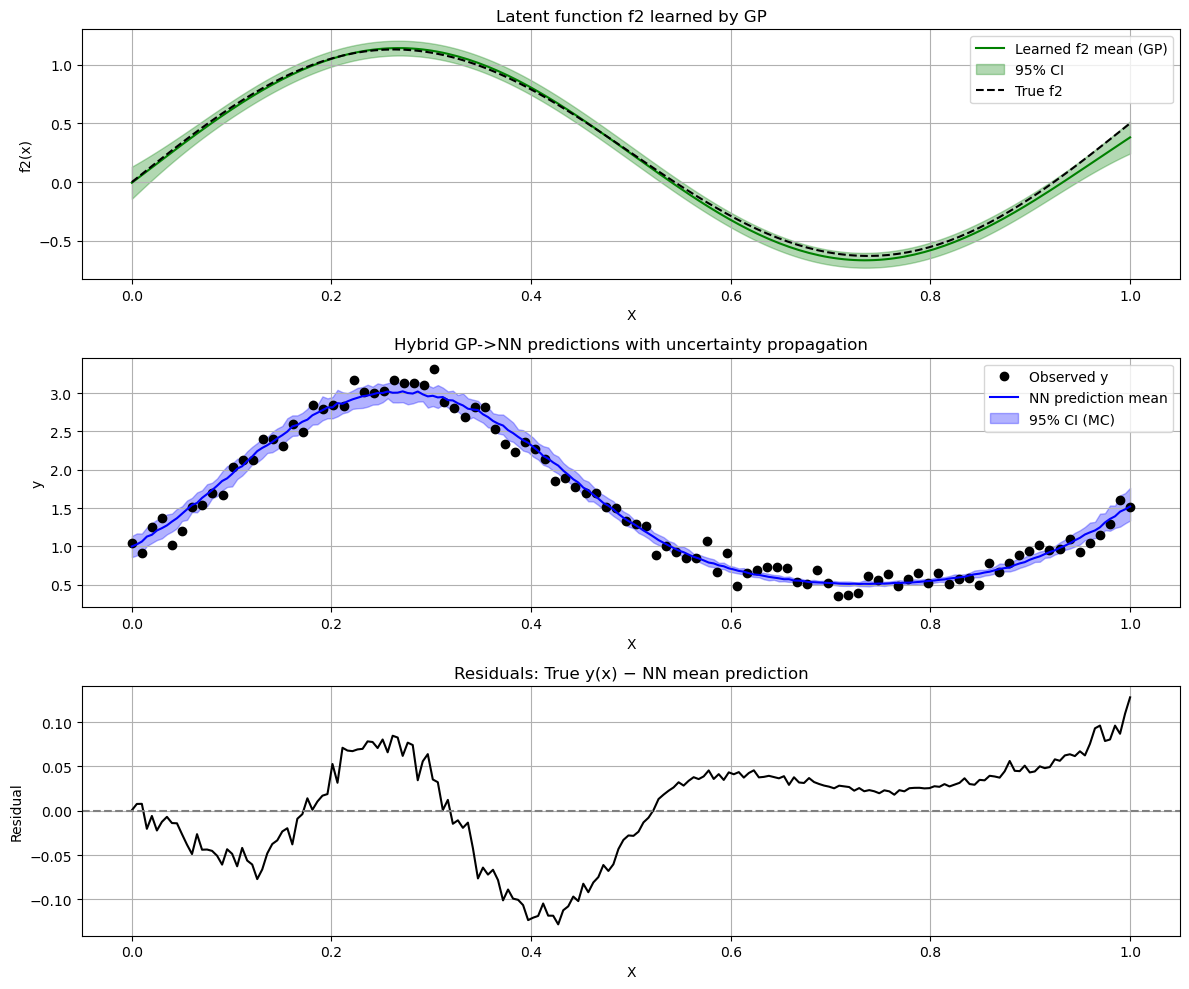

In [32]:
rng = np.random.default_rng(42)

def f2_true(x):            
    return np.sin(2*np.pi*x) + 0.5*x

def f1(z):                 
    return np.exp(z)   # known outer function

n = 100
X = np.linspace(0, 1, n)[:, None]
sigma_y = 0.15
y = f1(f2_true(X)).ravel() + rng.normal(0, sigma_y, size=n)

# -------------------------
# 2. Fit GP to learn latent f2
# -------------------------
# Use pseudo-inversion for simplicity
f2_pseudo = np.log(y)

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.2, length_scale_bounds=(1e-2, 1e2))
gp_f2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=sigma_y**2)
gp_f2.fit(X, f2_pseudo)

# Predict latent f2 at dense inputs
X_star = np.linspace(0, 1, 200)[:, None]
f2_mean, f2_std = gp_f2.predict(X_star, return_std=True)
f2_hi = f2_mean + 1.96*f2_std
f2_lo = f2_mean - 1.96*f2_std

# -------------------------
# 3. Neural network for f1(f2)
# -------------------------
# Use GP predictions at training points X (not X_star)
f2_train_mean, _ = gp_f2.predict(X, return_std=True)
f2_tensor = torch.tensor(f2_train_mean.reshape(-1,1), dtype=torch.float32)
y_tensor  = torch.tensor(y.reshape(-1,1), dtype=torch.float32)

# Define a tiny NN
class TinyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.GELU(),
            nn.Linear(20, 10),
            nn.GELU(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        return self.net(x)

model = TinyNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(f2_tensor)
    loss = loss_fn(pred, y_tensor)
    loss.backward()
    optimizer.step()

# NN predictions
y_pred_nn = model(f2_tensor).detach().numpy().ravel()

f2_star_tensor = torch.tensor(f2_mean.reshape(-1,1), dtype=torch.float32)
y_pred_nn_star = model(f2_star_tensor).detach().numpy().ravel()

# -------------------------
# 4. Uncertainty propagation via Monte Carlo
# -------------------------
n_samples = 50
y_samples = []

for i in range(n_samples):
    # Sample f2 from GP posterior
    f2_sample = rng.normal(f2_mean, f2_std)
    f2_sample_tensor = torch.tensor(f2_sample.reshape(-1,1), dtype=torch.float32)
    # Pass through NN
    y_nn_sample = model(f2_sample_tensor).detach().numpy().ravel()
    y_samples.append(y_nn_sample)

y_samples = np.array(y_samples)
y_mean_mc = y_samples.mean(axis=0)
y_lo_mc, y_hi_mc = np.percentile(y_samples, [2.5, 97.5], axis=0)

# For residuals: true noise-free y on X_star and flat X* for plotting
y_true_star = f1(f2_true(X_star)).ravel()
X_pred_flat = X_star.ravel()

# -------------------------
# 5. Plot results (with residuals like your example)
# -------------------------
plt.figure(figsize=(12, 10))

# Top: latent f2
ax1 = plt.subplot(3,1,1)
ax1.plot(X_star, f2_mean, 'g', label="Learned f2 mean (GP)")
ax1.fill_between(X_star.ravel(), f2_lo, f2_hi, color='green', alpha=0.3, label="95% CI")
ax1.plot(X, f2_true(X), 'k--', label="True f2")
ax1.set_xlabel("X")
ax1.set_ylabel("f2(x)")
ax1.set_title("Latent function f2 learned by GP")
ax1.legend()
ax1.grid(True)

# Middle: y predictions with propagated uncertainty
ax2 = plt.subplot(3,1,2)
ax2.plot(X, y, 'o', color='black', label="Observed y")
ax2.plot(X_star, y_mean_mc, 'b', label="NN prediction mean")
ax2.fill_between(X_star.ravel(), y_lo_mc, y_hi_mc, color='blue', alpha=0.3, label="95% CI (MC)")
ax2.set_xlabel("X")
ax2.set_ylabel("y")
ax2.set_title("Hybrid GP->NN predictions with uncertainty propagation")
ax2.legend()
ax2.grid(True)

# Bottom: residuals — True y(x) − NN prediction mean
ax3 = plt.subplot(3,1,3)
residuals = y_true_star - y_mean_mc
ax3.plot(X_pred_flat, residuals, 'k', lw=1.5)
ax3.axhline(0, color='gray', linestyle='--')
ax3.set_title("Residuals: True y(x) − NN mean prediction")
ax3.set_xlabel("X")
ax3.set_ylabel("Residual")
ax3.grid(True)

plt.tight_layout()
plt.show()
